In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

DEFAULT_SEED = 42

from gaussian import MultivariateNormal, DynamicMultivariateNormal, VarianceExploding, VariancePreserving, SubVariancePreserving

In [77]:
num_sides = 6
th = 2.0 * np.pi / num_sides
rot_th = np.array([[np.cos(th), -np.sin(th)], [np.sin(th), np.cos(th)]])

var = np.diag([5.0, 0.5])
mean = np.array([0.0, -10.0])
mean_offset = np.array([20.0, 10.0])
norms = []
for _ in range(num_sides):
    norms.append(DynamicMultivariateNormal(2, mean + mean_offset, var))
    var = rot_th @ var @ rot_th.T
    mean = rot_th @ mean

### Forward time SDE

In [78]:
def simulate(mix, tf=1.0, nt=50_000, num_save=200, num_sample=2000, seed=DEFAULT_SEED):
    x_init = mix.sample(num_sample)
    dt = tf / nt
    t = np.linspace(0.0, tf, nt + 1)

    save_every = nt // num_save
    x = x_init[:, None, :].repeat(num_save + 1, 1)

    rng = np.random.default_rng(seed)

    x_cur = x_init
    for i in range(1, nt + 1):
        t_cur = t[i - 1]
        dw = np.sqrt(dt) * rng.normal(size=x_cur.shape)
        x_cur = x_cur + dt * mix.f(t_cur, x_cur) + mix.g(t_cur) * dw
        if i % save_every == 0:
            x[:, i // save_every, :] = x_cur

    return t[::save_every], x


def plot_simulation(mix, t, x, show_every=50):
    num_plots = (len(t) - 1) // show_every + 1
    fig, ax = plt.subplots(1, num_plots, figsize=(15, 3))


    for i in range(num_plots):
        si = i * show_every
        ti = t[si]
        xi = x[:, si, :]

        x1_cont = np.linspace(xi[:, 0].min() - 1.0, xi[:, 0].max() + 1.0, 200)
        x2_cont = np.linspace(xi[:, 1].min() - 1.0, xi[:, 1].max() + 1.0, 200)
        x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
        x1_quiv = x1_cont[5::10]
        x2_quiv = x2_cont[5::10]
        x_quiv = np.stack(np.meshgrid(x1_quiv, x2_quiv), -1)
        score, div_score = mix.score_with_div(ti, x_quiv)
    
        ax[i].scatter(*xi.T, s=1)
        ax[i].contour(x_cont[:, :, 0], x_cont[:, :, 1], np.log(1e-8 + mix.density(ti, x_cont)), levels=10, alpha=0.5, cmap="plasma")
        ax[i].quiver(x_quiv[:, :, 0], x_quiv[:, :, 1], score[:, :, 0], score[:, :, 1], div_score, alpha=0.8)
    return fig, ax

#### No movement

(<Figure size 1500x300 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

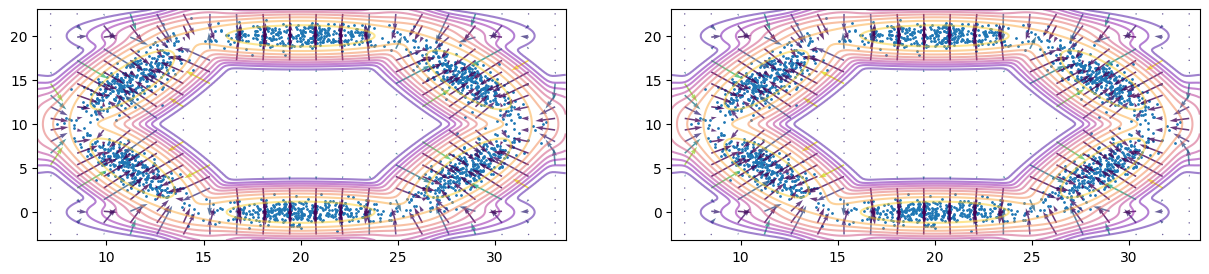

In [79]:
mix = VarianceExploding(tuple(norms))

mix.g = lambda t: 0.0
mix.g_sq = lambda t: 0.0
mix.added_noise = lambda t: 0.0
mix.added_noise_sq = lambda t: 0.0

t, x = simulate(mix, tf=10.0, nt=1_000, num_save=1)
plot_simulation(mix, t, x, show_every=1)

#### Pure noise

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

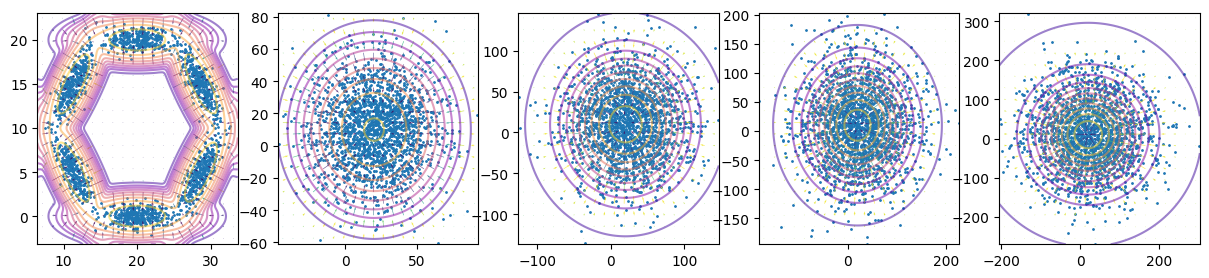

In [80]:
mix = VarianceExploding(tuple(norms))

t, x = simulate(mix, tf=80.0)
plot_simulation(mix, t, x)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

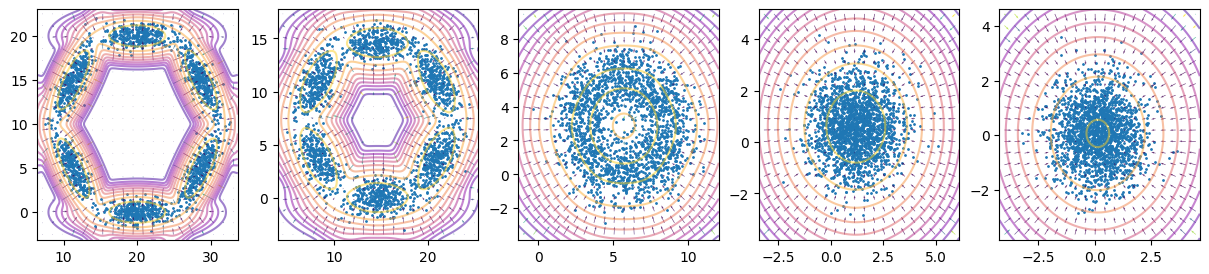

In [81]:
mix = VariancePreserving(tuple(norms))

t, x = simulate(mix)
plot_simulation(mix, t, x)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

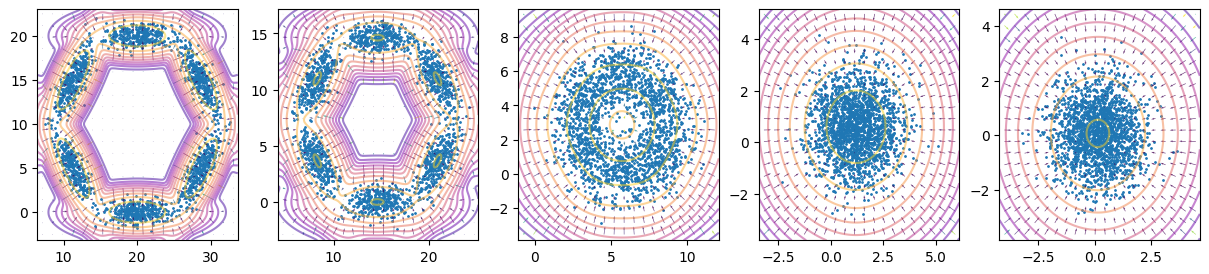

In [82]:
mix = SubVariancePreserving(tuple(norms))

t, x = simulate(mix)
plot_simulation(mix, t, x)

### Score-matching

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

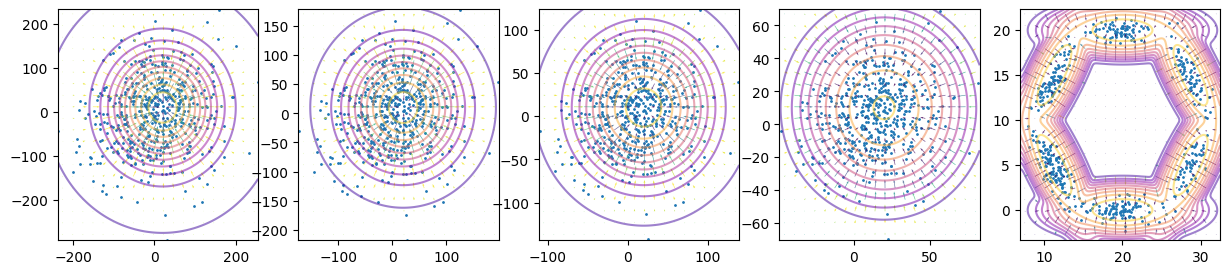

In [83]:
t_min = 1e-6

# tf = 1.0
# mix = VariancePreserving(tuple(norms))
# prior = MultivariateNormal(mix.dim)

tf = 80.0
mix = VarianceExploding(tuple(norms))
prior = MultivariateNormal(mix.dim, cov=mix.added_noise_sq(tf))

def backwards_ode(t, x_flat):
    x = x_flat.reshape(-1, mix.dim)
    return -mix.ode(tf - t, x).flatten()

num_sample = 500
num_save = 2000

x_noisy = prior.sample(num_sample)
t_eval = np.linspace(t_min, tf, num_save + 1)

sol = solve_ivp(backwards_ode, (t_min, tf), x_noisy.flatten(), rtol=1e-10, atol=1e-10, t_eval=t_eval)
t = tf - sol.t
x = sol.y.reshape(num_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
plot_simulation(mix, t, x, show_every=500)

(<Figure size 1500x300 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

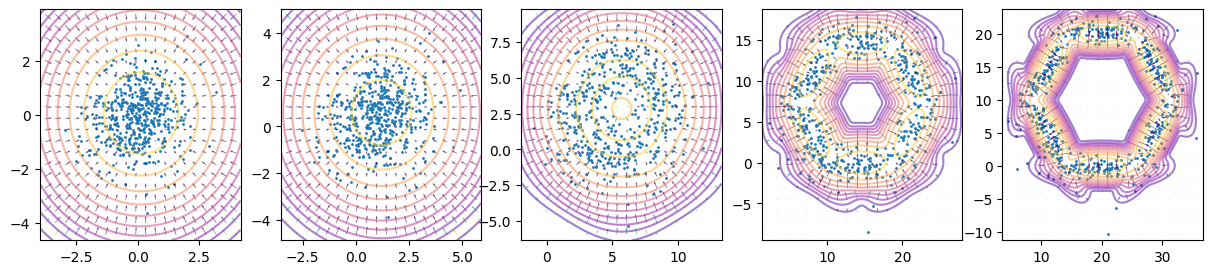

In [89]:
t_min = 1e-6

tf = 1.0
mix = VariancePreserving(tuple(norms))
prior = MultivariateNormal(mix.dim)

# tf = 80.0
# mix = VarianceExploding(tuple(norms))
# prior = MultivariateNormal(mix.dim, cov=mix.added_noise_sq(tf))

def backwards_ode(t, x_flat):
    x = x_flat.reshape(-1, mix.dim)
    return -mix.ode(tf - t, x).flatten()

num_sample = 500
num_save = 2000

x_noisy = prior.sample(num_sample)
t_eval = np.linspace(t_min, tf, num_save + 1)

sol = solve_ivp(backwards_ode, (t_min, tf), x_noisy.flatten(), rtol=1e-10, atol=1e-10, t_eval=t_eval)
t = tf - sol.t
x = sol.y.reshape(num_sample, mix.dim, num_save + 1).transpose(0, 2, 1)
plot_simulation(mix, t, x, show_every=500)

### Negative log-likelihood

In [84]:
def compute_quasi_exact_nll(mix, prior, n_data=5000, t_min=1e-6, tf=1.0):
    def flat_extended_ode(t, x_cumdiv_flat):
        x, _ = np.split(x_cumdiv_flat.reshape(-1, mix.dim + 1), [mix.dim], -1)
        dx, dlogp = mix.extended_ode(t, x)
        return np.concatenate([dx, dlogp], 1).flatten()

    x_data = mix.sample(n_data)
    delta_logp = np.zeros((n_data, 1))
    x_logp_init = np.concatenate([x_data, delta_logp], axis=1)

    t_eval = np.array([t_min, 0.5, tf])
    sol = solve_ivp(flat_extended_ode, (t_min, tf), x_logp_init.flatten(), rtol=1e-10, atol=1e-10, t_eval=t_eval)

    x_logp_fin = sol.y[:, -1].reshape(n_data, mix.dim + 1)
    x, delta_logp = np.split(x_logp_fin, [mix.dim], -1)
    prior_fin = np.log(prior.density(x))
    return x, -(delta_logp[:, 0] + prior_fin).mean() / np.log(2.0) / mix.dim

Text(0.5, 1.0, 'NLL: 0.95')

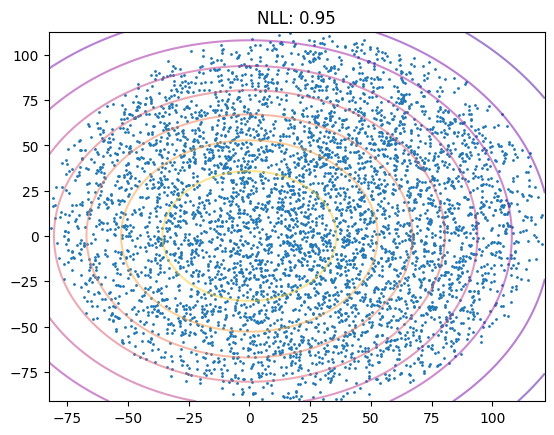

In [85]:
tf = 80.0
mix = VarianceExploding(tuple(norms))
prior = MultivariateNormal(mix.dim, cov=mix.added_noise_sq(tf))
x, nll = compute_quasi_exact_nll(mix, prior, tf=tf)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")

Text(0.5, 1.0, 'NLL: 3.90')

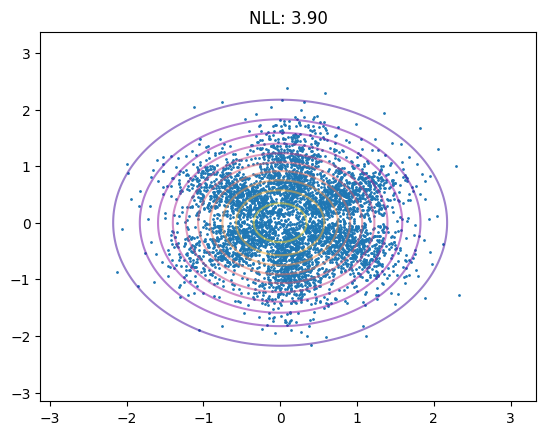

In [90]:
mix = VariancePreserving(tuple(norms))
prior = MultivariateNormal(mix.dim)
x, nll = compute_quasi_exact_nll(mix, prior)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")

In [117]:
x0 = norms[0].sample(1000)
div_from_div = norms[0].score_with_div(x0)[1]
div_from_jac = np.linalg.trace(norms[0].score_with_jac(x0)[1])
np.abs(div_from_div - div_from_jac).max()

np.float64(0.0)

In [134]:
x0 = norms[1].sample(1000)
div_from_div = norms[1].score_with_div(x0)[1]
div_from_jac = np.linalg.trace(norms[1].score_with_jac(x0)[1])
np.abs(div_from_div - div_from_jac).max()

np.float64(4.440892098500626e-16)

In [155]:
from gaussian import Mixture
mix = Mixture(tuple(norms))
x0 = mix.sample(1000)
div_from_div = mix.score_with_div(x0)[1]
div_from_jac = np.linalg.trace(mix.score_with_jac(x0)[1])[..., None]
np.abs(div_from_div - div_from_jac).max()

np.float64(1.0658141036401503e-14)

In [ ]:
x0 = mix.sample(1000)
div_from_div = mix.score_with_div(0.0, x0)[1]
div_from_jac = np.linalg.trace(mix.score_with_jac(0.0, x0)[1])
np.abs(div_from_div - div_from_jac[:, None]).max()

np.float64(5.185051969838721)

Text(0.5, 1.0, 'NLL: 3.94')

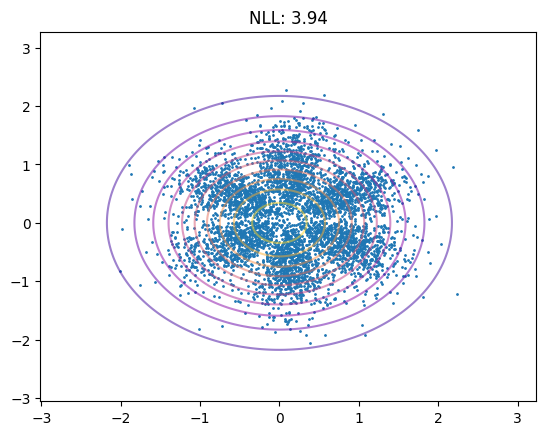

In [91]:
mix = SubVariancePreserving(tuple(norms))
prior = MultivariateNormal(mix.dim)
x, nll = compute_quasi_exact_nll(mix, prior)
plt.scatter(*x.T, s=1)

x1_cont = np.linspace(x[:, 0].min() - 1.0, x[:, 0].max() + 1.0, 200)
x2_cont = np.linspace(x[:, 1].min() - 1.0, x[:, 1].max() + 1.0, 200)
x_cont = np.stack(np.meshgrid(x1_cont, x2_cont), -1)
plt.contour(x_cont[:, :, 0], x_cont[:, :, 1], prior.density(x_cont), levels=10, alpha=0.5, cmap="plasma")

plt.title(f"NLL: {nll:.2f}")